In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsepy import get_history
from datetime import date

In [51]:
data=pd.read_csv('HDFCBANK.NS.csv')

In [52]:
data['Date']=pd.to_datetime(data['Date'])
data=data.set_index(['Date'])

In [53]:
#This is how our stock data looks like
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-14,1422.099976,1424.150024,1406.650024,1410.699951,1392.494141,1788755
2017-03-15,1410.949951,1420.000000,1410.550049,1416.599976,1398.317993,1067965
2017-03-16,1418.099976,1422.849976,1413.650024,1417.349976,1399.058228,1245027
2017-03-17,1418.550049,1427.500000,1412.849976,1425.849976,1407.448608,847616
2017-03-20,1426.650024,1439.849976,1425.949951,1436.099976,1417.566284,2035586


In [54]:
 #We need closing price of stocks only so we have filtered out all the columns except closing price
data=data.filter(['Close']) 

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 493 entries, 2017-03-14 to 2019-03-08
Data columns (total 1 columns):
Close    493 non-null float64
dtypes: float64(1)
memory usage: 7.7 KB


In [58]:
data.describe()

,Close
count,493.000000
mean,1890.672514
std,194.544621
min,1409.849976
25%,1791.050049
50%,1900.150024
75%,2057.600098
max,2202.149902


In [55]:
data.head()

,Close
Date,
2017-03-14,1410.699951
2017-03-15,1416.599976
2017-03-16,1417.349976
2017-03-17,1425.849976
2017-03-20,1436.099976


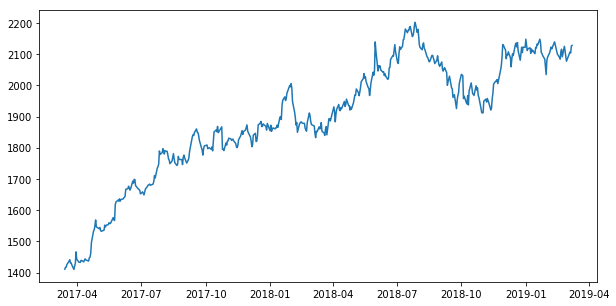

In [63]:
#Visuazling the stock price movement
plt.figure(figsize=(10,5))
plt.plot(data.Close)
plt.show()

In [73]:
#Calculating the daily return of data set
daily_return=data['Close'].pct_change(1)
#calculating daily log return
#Logarithmic return
log_ret=np.log(data['Close']/data['Close'].shift(1))
log_ret.head()

Date
2017-03-14         NaN
2017-03-15    0.004174
2017-03-16    0.000529
2017-03-17    0.005979
2017-03-20    0.007163
Name: Close, dtype: float64

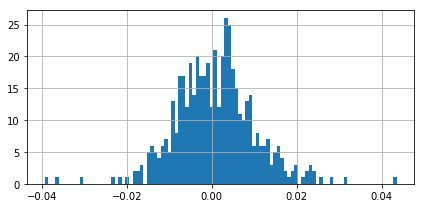

In [76]:
#plotting log return histogram
log_ret.hist(bins=100,figsize=(6,3))
plt.tight_layout()

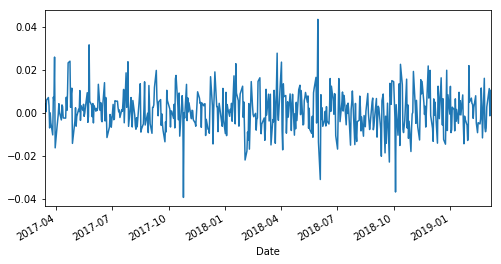

In [112]:
#plotting log return curve
plt.figure(figsize=(8,4))
log_ret.plot()
plt.show()

In [80]:
#Mean daily return of stock is:
print("Mean daily return of stock ",log_ret.mean()*100,"%")

Mean daily return of stock  0.08357531069868955 %


# Implementing LSTM model for price prediction

In [81]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

In [95]:
def DatasetCreation(dataset, TimeStep=1):
    DataX, DataY = [], []
    for i in range(len(dataset)-TimeStep-1):
        a=dataset[i:(i+TimeStep), 0]
        DataX.append(a)
        DataY.append(dataset[i + TimeStep, 0])
    return np.array(DataX), np.array(DataY)


scaler = MinMaxScaler()
DataScaled = scaler.fit_transform(data)

np.random.seed(7)

TrainLen = int(len(DataScaled) * 0.70)
TestLen = len(DataScaled) - TrainLen
TrainData = DataScaled[0:TrainLen,:] 
TestData  = DataScaled[TrainLen:len(DataScaled),:]

print("Length of train data",len(TrainData),"\nLength of test data", len(TestData))

TimeStep = 1
TrainX, TrainY = DatasetCreation(TrainData, TimeStep)
TestX, TestY = DatasetCreation(TestData, TimeStep)

TrainX = np.reshape(TrainX, (TrainX.shape[0], 1, TrainX.shape[1]))
TestX = np.reshape(TestX, (TestX.shape[0], 1, TestX.shape[1]))
    

Length of train data 345 
Length of test data 148


# Creating model

In [97]:

model = Sequential()
model.add(LSTM(256, input_shape=(1, TimeStep)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(TrainX, TrainY, epochs=5, batch_size=1, verbose=1)
model.summary()

Epoch 1/5
343/343 [==============================] - 4s 13ms/step - loss: 0.0390 - acc: 0.0029
Epoch 2/5
343/343 [==============================] - 3s 10ms/step - loss: 0.0050 - acc: 0.0058
Epoch 3/5
343/343 [==============================] - 3s 10ms/step - loss: 0.0013 - acc: 0.0058
Epoch 4/5
343/343 [==============================] - 3s 10ms/step - loss: 0.0013 - acc: 0.0058
Epoch 5/5
343/343 [==============================] - 3s 10ms/step - loss: 0.0013 - acc: 0.0058
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [98]:
score = model.evaluate(TrainX, TrainY, verbose=0)
print('Keras Model Loss = ',score[0])
print('Keras Model Accuracy = ',score[1])

Keras Model Loss =  0.0012098670307188445
Keras Model Accuracy =  0.005830903844391987


In [99]:
TrainPred = model.predict(TrainX)
TestPred = model.predict(TestX)

TrainPred = scaler.inverse_transform(TrainPred)
TrainY = scaler.inverse_transform([TrainY])

TestPred = scaler.inverse_transform(TestPred)
TestY = scaler.inverse_transform([TestY])

TrainPredictPlot = np.empty_like(DataScaled)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[1:len(TrainPred)+1, :] = TrainPred

TestPredictPlot = np.empty_like(DataScaled)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(TrainPred)+(1*2)+1:len(DataScaled)-1, :] = TestPred


# Predicting the price

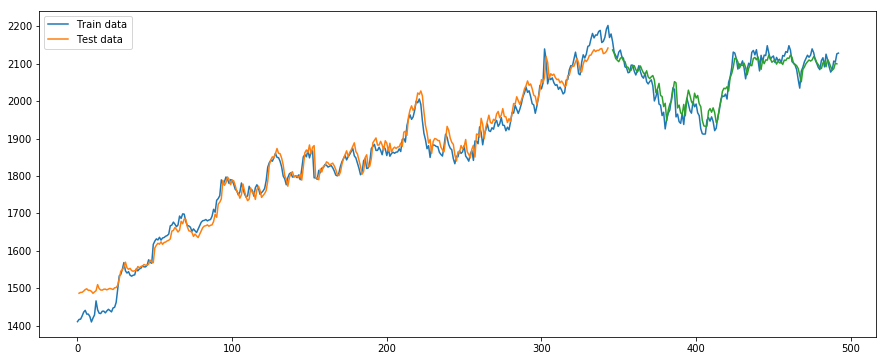

In [110]:
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(DataScaled))
plt.plot(TrainPredictPlot)
plt.legend(('Train data','Test data'))
plt.plot(TestPredictPlot)
plt.show()